In [5]:
import numpy as np
import random as r
from matplotlib import pyplot as plt

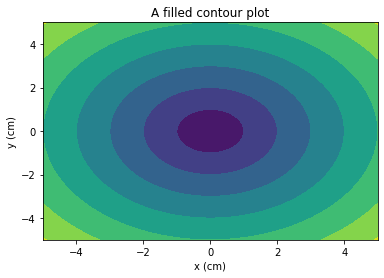

In [10]:
import numpy as np
import matplotlib.pyplot as plt
x = np.linspace(-5.0, 5.0, 120)
y = np.linspace(-5.0, 5.0, 120)
X, Y = np.meshgrid(x, y)
Z = np.sqrt(X**2 + Y**2)
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, Z)

ax.set_title('A filled contour plot')
ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
plt.show()

In [4]:
class NeuralNetwork:
    def __init__(self, shape, cost, activation_fn, dropout=False):

        # cost function
        self.cost = getattr(self, cost)
        # activation function
        self.activation_fn, self.dactivation_fn = None, None
        self.set_activation_function(activation_fn)
        # learning rate
        self.learning_rate = None
        # initialize all data containers involved in neural network training
        self.input, self.target = None, None
        self.act, self.dw_sum = None, None
        self.w, self.b = None, None
        self.dCdact, self.dCdw, self.dCdb = None, None, None
        self.create_network_structure(shape)
        # dropout regularizer
        self.dropout, self.mask = None, None
        self.set_dropout(dropout, shape)
        # vanilla momentum and Nesterov momentum SGD
        self.run_momentum, self.run_nesterov = None, None
        self.v_dw, self.v_db = None, None
        self.w_initial, self.b_initial = None, None
        self.set_momentum(shape)
        # ADAM optimizer
        self.run_adam = None
        self.iterations = None
        self.s_dw, self.s_db = None, None
        self.set_adam(shape)

    # functions called implicitly when creating neural network

    def set_adam(self, shape):
        self.run_adam = False
        self.iterations = 0
        self.s_dw = np.array([np.zeros((shape[i + 1], shape[i])) for i in range(len(shape) - 1)])
        self.s_db = np.array([np.zeros((1, shape[i]))[0] for i in range(1, len(shape))])

    def set_momentum(self, shape):
        self.run_momentum, self.run_nesterov = False, False
        self.v_dw = np.array([np.zeros((shape[i + 1], shape[i])) for i in range(len(shape) - 1)])
        self.v_db = np.array([np.zeros((1, shape[i]))[0] for i in range(1, len(shape))])
        self.w_initial, self.b_initial = 0, 0

    def set_dropout(self, dropout, shape):
        self.dropout = dropout  # contains the keep probabilities for input and hidden layers
        self.mask = np.array([np.full((1, shape[i]), 1)[0] for i in range(len(shape))])

    def set_activation_function(self, activation_fn):
        self.activation_fn = getattr(self, activation_fn)
        self.dactivation_fn = getattr(self, 'd' + activation_fn)

    def create_network_structure(self, shape):
        self.input, self.target = 0, 0
        self.act = np.zeros((1, len(shape)), dtype=object)[0]  # array of all activations in the neural network
        self.dw_sum = np.zeros((1, len(shape) - 1), dtype=object)[0]  # array of all sigmoid'(weighted sum) in every neuron
        self.w = np.array([np.random.randn(shape[i + 1], shape[i]) * np.sqrt(1 / shape[i]) for i in range(len(shape) - 1)])
        self.b = np.array([np.full((1, shape[i]), 0)[0] for i in range(1, len(shape))])  # array of all biases in the neural network (keep same b for each minibatch)
        self.dCdact = np.zeros((1, len(shape)), dtype=object)[0]  # array of all derivatives of cost function with respect to all individual activations
        self.dCdw = np.array([np.full((shape[i + 1], shape[i]), 0) for i in range(len(shape) - 1)])  # cost gradient with respect to w
        self.dCdb = np.array([np.full((1, shape[i]), 0)[0] for i in range(1, len(shape))])  # cost gradient with respect to b


    # main training algorithm (propagation of error through network)

    def forward_prop(self, *dropout_error_calc):
        self.act[0] = np.array(self.input)
        for l in range(len(self.w)):
            self.dropout_forward(self.act[l], l, dropout_error_calc)
            # compute all activations in layer (act_l)
            act_l = np.tensordot(self.act[l], self.w[l], (0, 1)) + self.b[l]
            self.dw_sum[l] = self.dactivation_fn(np.ravel(act_l))
            self.act[l + 1] = self.activation_fn(np.ravel(act_l))

    def backprop(self):
        for l in range(len(self.act) - 1, 0, -1):
            # fetch all dC/dact for current layer (dC/dact_l) and place into dC/dact array
            dCdact_l = self.comp_dCdact(l)
            self.dCdact[l] = dCdact_l
            # calculate dC/dW for all weights in layer (dC/dw_l)
            dCdw_l = np.matmul(np.transpose([self.act[l - 1]]), [self.dw_sum[l - 1]])
            dCdw_l = np.multiply(dCdw_l, np.transpose(self.dCdact[l]))
            # calculate dC/dB for all biases in layer (dC/db_l)
            dCdb_l = np.multiply(self.dw_sum[l - 1], self.dCdact[l])
            # set cost gradient
            self.dCdw[l - 1] = np.transpose(dCdw_l)
            self.dCdb[l - 1] = dCdb_l
        self.dropout_back()

    def comp_dCdact(self, l):
        # special case for output layer
        if l == len(self.act) - 1:
            return self.cost()
        # compute dCdact for inner layers
        a = np.transpose(self.w[l])
        b = self.dw_sum[l]
        dAdact = np.multiply(a, b)
        return np.matmul(dAdact, np.transpose(self.dCdact[l + 1]))

    # cost functions

    def cross_entropy(self):
        self.dw_sum[-1] = np.full((1, len(self.dw_sum[-1])), 1)[0]
        return np.subtract(self.act[-1], self.target)

    def mean_squared(self):
        return 2 * np.subtract(self.act[-1], self.target)

    # function to call to train network

    def train(self, file1, file2, epochs, batch_size, lr, lmbda=1, run_momentum=False, run_nesterov=False,
              run_adam=False):
        self.learning_rate = lr
        self.run_momentum, run_nesterov, run_adam = run_momentum, run_nesterov, run_adam
        data = self.file_to_data(file1, file2)
        train_data, test_data = data[0], data[1]
        # update arrays
        dCdw_update, dCdb_update = 0, 0
        # create new mask for dropout
        self.new_mask()
        for i in range(epochs):  # number of times train through entire training set
            # randomize the training data
            r.shuffle(train_data)
            for j in range(len(train_data)):
                # feed training example into network
                self.input = train_data[j][1:]
                self.target = np.zeros((1, 10))[0]
                self.target[train_data[j][0]] = 1
                self.forward_prop()
                self.backprop()
                dCdw_update += self.dCdw
                dCdb_update += self.dCdb
                # perform batch update (dependent on batch size)
                if j % batch_size == 0 and j != 0 or j + 1 == len(train_data):
                    # apply L2 regularizer during every minibatch update
                    self.batch_update(dCdw_update, dCdb_update, batch_size)
                    self.weight_decay(lmbda, len(train_data))
                    # reset update arrays
                    dCdw_update, dCdb_update = 0, 0
                    # choose new neurons to be dropped
                    self.new_mask()
                    if j + 1 == len(train_data):
                        print('Percent correct (Training):', self.error_calc(train_data))
                        print('Percent correct (Testing) :', self.error_calc(test_data))
                    self.nesterov_momentum(look_ahead=True)

    # batch update for mini-batch gradient descent
    def batch_update(self, dCdw_update, dCdb_update, batch_size):
        self.dCdw = dCdw_update / batch_size
        self.dCdb = dCdb_update / batch_size
        if self.run_momentum:  # add momentum to batch update
            self.momentum()
        elif self.run_nesterov:
            self.nesterov_momentum()
        elif self.run_adam:
            self.adam_optimizer()
        else:
            self.w -= self.learning_rate * self.dCdw
            self.b -= self.learning_rate * self.dCdb

    # calculating the error at end of every epoch
    def error_calc(self, data):
        num_correct = 0
        for j in range(len(data)):
            self.input = data[j][1:]
            self.target = np.zeros((1, 10))[0]
            self.target[data[j][0]] = 1
            self.forward_prop(True)  # don't run dropout during testing
            # error criteria
            if np.argmax(self.act[-1]) == data[j][0]:
                num_correct += 1
        return num_correct / len(data)

    # function to parse file data into programmable data
    def file_to_data(self, file1, file2):
        train_file = open(file1, 'r').readlines()
        test_file = open(file2, 'r').readlines()
        train_data = list()
        test_data = list()
        for line in train_file[1:]:  # skip header line
            # convert all training data to normalized floating values using map()
            train_input = list([int(line[0])]) + list(map(lambda x: float(x) / 255, line.split(',')[1:]))
            # add to training data array
            train_data.append(train_input)
        for line in test_file[1:]:  # skip header line
            # convert all test data to normalized floating values using map()
            test_input = list([int(line[0])]) + list(map(lambda x: float(x) / 255, line.split(',')[1:]))
            # add to test data array
            test_data.append(test_input)
        return train_data, test_data

    # group of activation functions to choose from and their respective derivatives
    def ReLU(self, sum):
        sum[sum < 0] = 0
        return sum

    def dReLU(self, sum):
        sum[sum > 0] = 1
        sum[sum <= 0] = 0
        return sum

    def sigmoid(self, sum):
        return 1 / (1 + np.e ** (-sum))

    def dsigmoid(self, sum):
        return (np.e ** (-sum)) / ((1 + np.e ** (-sum)) ** 2)

    # L2 Regularizer
    def weight_decay(self, lmbda, n):
        scaling_factor = 1 - self.learning_rate * lmbda / n
        # rescale the weights
        self.w *= scaling_factor

    # dropout regularizer and associated functions
    def new_mask(self):
        if not self.dropout:
            return
        for l in range(len(self.mask) - 1):
            if l == 0:
                keep_prob = self.dropout[0]
            else:
                keep_prob = self.dropout[1]
            # apply inverted dropout
            self.mask[l] = np.random.binomial(1, keep_prob, len(self.mask[l])) / keep_prob

    def dropout_forward(self, act_l, l, dropout_error_calc):
        if not self.dropout or bool(dropout_error_calc):
            return
        act_l *= self.mask[l]

    def dropout_back(self):
        if not self.dropout:
            return
        # update dCdb and dCdw to reflect dropped out neurons
        self.dCdb *= self.mask[1:]
        for l in range(len(self.dCdw)):
            self.dCdw[l] = np.transpose(np.multiply(np.transpose(self.dCdw[l]), self.mask[l + 1]))

    def bias_correction(self, beta, *args):
        if not args:
            return
        for items in args:
            items /= (1 - beta ** self.iterations)

    def learning_rate_decay(self):
        self.learning_rate /= np.sqrt(self.iterations)

In [9]:
from NeuralNetwork import *

if __name__ == '__main__':
    # For training, parameters of 5 epochs, a mini batch size of 10, a learning rate of 0.1, and a l2 value 1.0 were used here.
    NN = NeuralNetwork([784, 100, 10], cost='cross_entropy', activation_fn='sigmoid', dropout=(0.9, 0.5))
    NN.train('mnist_train.csv', 'mnist_test.csv', 5, 10, 0.1, lmbda=1.0)

Percent correct (Training): 0.9216833333333333
Percent correct (Testing) : 0.9273
Percent correct (Training): 0.9365333333333333
Percent correct (Testing) : 0.9383
Percent correct (Training): 0.9448833333333333
Percent correct (Testing) : 0.9446
Percent correct (Training): 0.9505166666666667
Percent correct (Testing) : 0.9491
Percent correct (Training): 0.9544
Percent correct (Testing) : 0.9524
